# CODICE COME MAIN_METROPOLIS_LU CHE CERCA DI USARE IL NETWORK DEL PROF 14/05/2025
Codice che funziona, bisogna provare a farlo runnare per vedere quanto ci mette a trovare le accuracies

## 1 Initialize the Network

In [2]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations
import seaborn as sns

In [3]:
# Carica la matrice fc (ad esempio dal file fc.txt)
fc = np.loadtxt('fc.txt')

# Crea la matrice A0 inizialmente vuota (di dimensioni 100x100)
n = fc.shape[0]
A_true = np.zeros((n, n))

# Per ogni coppia di nodi (i, j), crea una connessione se un numero casuale <= fc[i, j]
for i in range(n):
    for j in range(n):
        
        prob = fc[i, j]
        treshold= 0.3
        if prob >= treshold:
            A_true[i, j] = 1  # Connetti i nodi i e j
        

# Adjacent matrix 
print(A_true)

[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [4]:
# network creation
G_true = nx.from_numpy_array(A_true)

# Verifica numero di nodi e archi
print(f"Numero di nodi: {G_true.number_of_nodes()}")
print(f"Numero di archi: {G_true.number_of_edges()}")

Numero di nodi: 100
Numero di archi: 805


In [5]:
def modify_network(G, modification_fraction):
    """
    Randomly removes and adds a fraction of edges in the network G.
    
    :param G: The input graph (NetworkX object).
    :param modification_fraction: Fraction of edges to modify.
    :return: Modified graph, list of removed edges, list of added edges.
    """
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Randomly remove edges
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Randomly add edges
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges

In [6]:
# Create an observed network by randomly modifying the true graph
modification_fraction = 0.3 # For example, modify 20% of the connections
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)


# Verifica numero di nodi e archi
print(f"Numero di nodi: {G_obs.number_of_nodes()}")
print(f"Numero di archi: {G_obs.number_of_edges()}")

Numero di nodi: 100
Numero di archi: 792


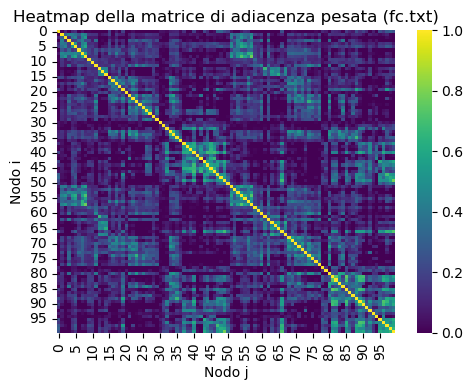

In [7]:
# === Heatmap della matrice di adiacenza ===
plt.figure(figsize=(5, 4))
sns.heatmap(fc, cmap='viridis')
plt.title('Heatmap della matrice di adiacenza pesata (fc.txt)')
plt.xlabel('Nodo j')
plt.ylabel('Nodo i')
plt.tight_layout()
plt.show()



In [8]:
##### PLOTS 
def plot_graph(G, title):
    """
    Plots the given graph with node colors based on their block assignment.

    :param G: NetworkX graph object.
    """
    pos = nx.spring_layout(G, k=0.8, seed=42)  # Adjust 'k' to control node spacing
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        edge_color='darkgrey', 
        node_color='skyblue', 
        node_size=300,  # Increase node size
        width=1.5,  # Increase edge width
        font_size=10, 
        font_color='black'
    )
    plt.title(title)
    plt.show()

def plot_modified_network(G, removed_edges, added_edges, title):
    """
    Plots the observed network with highlighted removals and additions.

    :param G: NetworkX graph object.
    :param removed_edges: List of edges removed from the original graph.
    :param added_edges: List of edges added to the original graph.
    :param title: Title of the plot.
    """
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Adjust 'k' to control node spacing
    
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        node_color='skyblue', 
        edge_color='gray', 
        node_size=300,  # Increase node size
        width=1.5,  # Increase edge width
        font_size=10, 
        font_color='black'
    )
    # Highlight removed edges in red (dashed)
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=1)
    # Highlight added edges in green (solid)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=1)
    
    plt.title(title)
    plt.show()
    


def plot_H_trace(H_burn_in, H_full_trace):
    """
    Plots the full trace of H(P), including the burn-in phase and sampling.

    :param H_burn_in: List of H(P) values during the burn-in phase.
    :param H_full_trace: List of H(P) values during the full MCMC sampling.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_burn_in)), H_burn_in, marker=',', linestyle='-', linewidth=0.5, label="Burn-in")
    plt.plot(range(len(H_burn_in), len(H_burn_in) + len(H_full_trace)), H_full_trace, marker=',', linestyle='-', linewidth=0.5, label="Sampling")
    plt.axvline(x=len(H_burn_in), color='r', linestyle='--', linewidth=1, label="End of burn-in")
    plt.xlabel("Iterations")
    plt.ylabel("H(P)")
    plt.title("Full Trace of H(P) Without Thinning")
    plt.legend()
    plt.show()


def plot_final_H_trace(H_final, thinning_interval):
    """
    Plots the final trace of H(P) after applying thinning.

    :param H_final: List of H(P) values after thinning.
    :param thinning_interval: Interval used for thinning.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_final)), H_final, marker='o', linestyle='-')
    plt.xlabel(f'Sampling iterations with thinning every {thinning_interval}')
    plt.ylabel('H(P)')
    plt.title('Final Trace of H(P) After Thinning')
    plt.show()


def plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious):
    """
    Plots the accuracy for Missing and Spurious Interactions.

    :param error_fractions: List of error fractions.
    :param accuracy_missing: Accuracy values for missing interactions.
    :param accuracy_spurious: Accuracy values for spurious interactions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for Missing Interactions
    ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
    ax1.set_xlabel('Fraction of removed links (f)')
    ax1.set_ylabel('Accuracy (probability)')
    ax1.set_title('Missing Interactions')
    ax1.legend()
    ax1.grid(True)

    # Plot for Spurious Interactions
    ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
    ax2.set_xlabel('Fraction of added links (f)')
    ax2.set_ylabel('Accuracy (probability)')
    ax2.set_title('Spurious Interactions')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


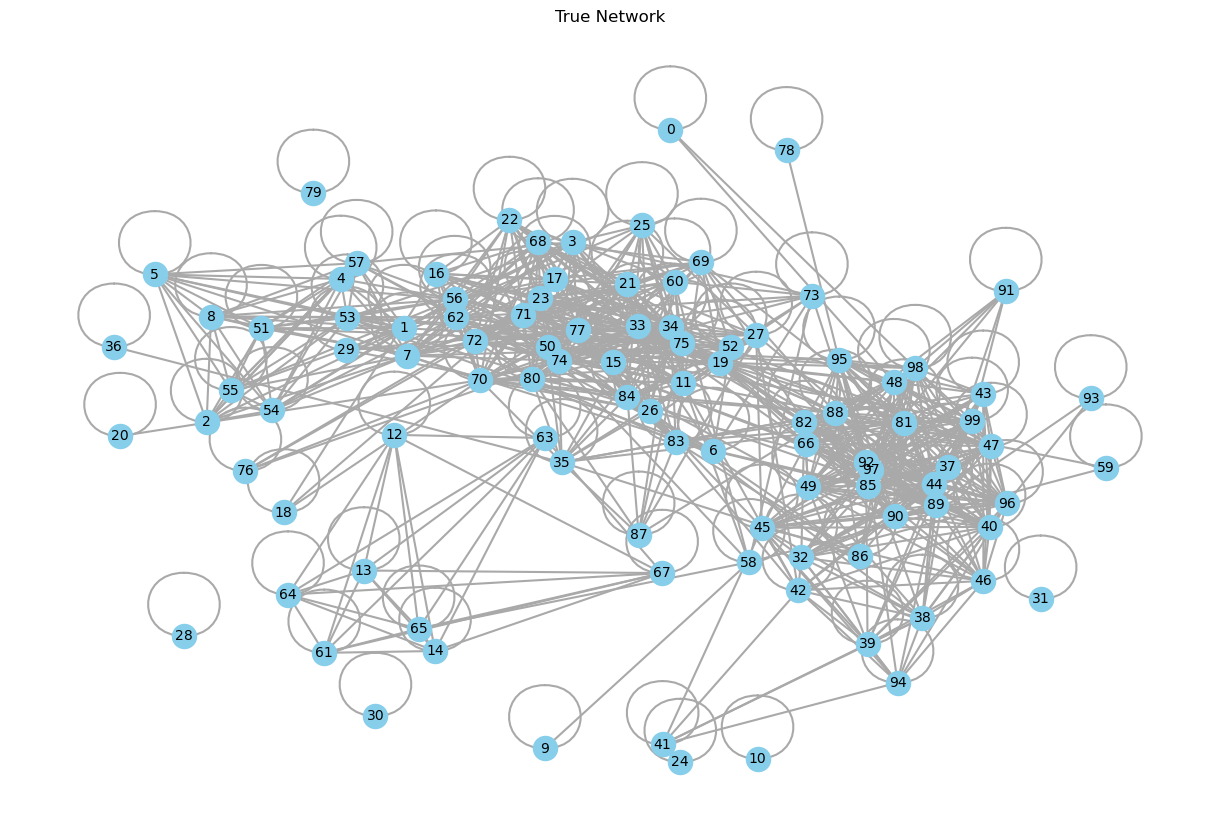

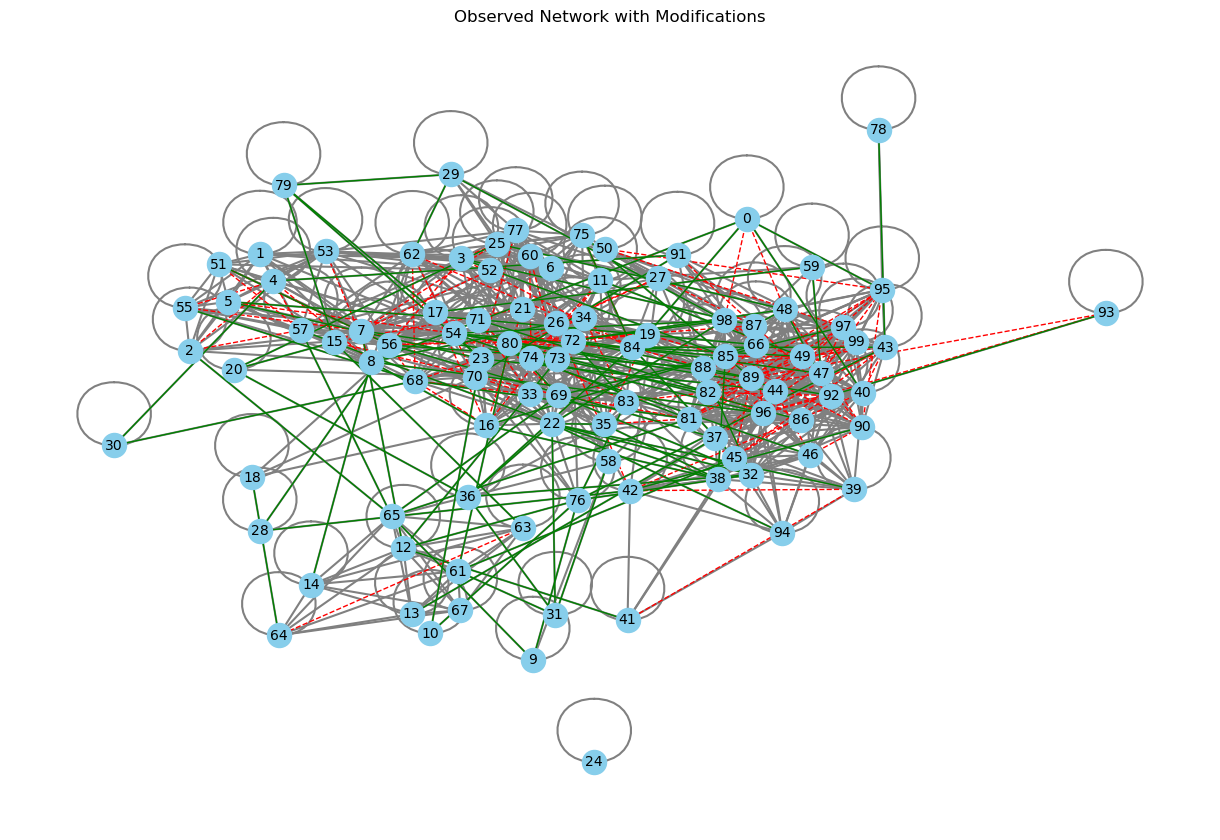

In [9]:
# Plot the true network
plot_graph(G_true, "True Network")

# Plot the observed network
plot_modified_network(G_obs, removed_edges, added_edges, "Observed Network with Modifications")

### 1.2 Computing Entropy in Network Partitions

In [10]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group


def calculate_H(P, G):
    """Calculates H(P) for a given partition P and graph G."""
    # Group nodes by block
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (maximum possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # Combinations of 2
    # Pairs of different groups
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Note: We add 1 to the denominator as per the formula and use log(comb) for the combinatorial term.
        H += math.log(r[key] + 1)
        # To avoid log(0) or errors, we use 0 if no observed links exist
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # For safety, if comb_value results in 0, we add a small epsilon
        H += math.log(comb_value)
    
    return H

# in caso aggiungo questo:
#if comb_value > 0:
    #H += math.log(comb_value)
#else:
    #H += 0


The formula for H(P) in your code:  
corresponds to the article's equation: [ H(P) = \sum_{\alpha \leq \beta} \left[ \ln(r_{\alpha\beta} + 1) + \ln\binom{r_{\alpha\beta}}{lO_{\alpha\beta}} \right] ]  
r[key] represents the maximum possible links between groups (denoted as ( r_{\alpha\beta} )).  
lO[key] represents the observed links between groups (denoted as ( lO_{\alpha\beta} )).  
The use of math.comb ensures the combinatorial term is calculated correctly.

### 1.3 MCMC Sampling for Network Partitions

This section introduces the Metropolis-Hastings MCMC algorithm to sample partitions of a given network. The function mcmc_trace_H performs the Markov Chain Monte Carlo (MCMC) sampling, first running a burn-in phase to reach equilibrium, then collecting partition samples without thinning. The acceptance criterion follows the Metropolis rule, ensuring that state transitions favor lower entropy configurations while allowing occasional increases for exploration. The output includes all recorded entropy values, enabling further analysis of the sampling process.

In [11]:
def metropolis_acceptance(delta_H):
    """Decides whether to accept a new state based on the Metropolis criterion."""
    return delta_H <= 0 or np.random.rand() < np.exp(-delta_H)


def mcmc_trace_H(G, equilibration, num_samples):
    """
    Performs MCMC sampling, collecting all H(P) values without thinning.

    :param G: NetworkX graph for sampling.
    :param equilibration: Number of burn-in iterations.
    :param num_samples: Total number of sampling iterations.
    :return: List of sampled partitions, H values during sampling, and full trace of H values.
    """
    num_nodes = len(G.nodes())
    P = initialize_partition(G)
    
    # Store H(P) values during burn-in
    H_burn_in = []
    for i in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        H_burn_in.append(calculate_H(P, G))  # Store all H(P) values in burn-in
    
    # Sampling phase without thinning
    partitions = []
    H_full_trace = []  # Stores all H(P) values during sampling without thinning
    for i in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        partitions.append(P.copy())
        H_full_trace.append(calculate_H(P, G))  # Records all H(P) values without thinning
    
    return partitions, H_burn_in, H_full_trace


L'equilibration nella funzione mcmc_trace_H rappresenta il numero di iterazioni iniziali della catena di Markov che vengono considerate come fase di burn-in. Durante questa fase, la catena non raccoglie campioni utili, ma si stabilizza verso una distribuzione stazionaria. Questo è necessario perché la catena parte da una configurazione iniziale arbitraria (ad esempio, una partizione casuale) e potrebbe richiedere un certo numero di passi per raggiungere uno stato rappresentativo della distribuzione target.

Come viene usato equilibration?  
Durante la fase di burn-in, i valori di entropia H(P) vengono calcolati e memorizzati nella lista H_burn_in, ma le partizioni non vengono raccolte per l'analisi finale.
Dopo la fase di burn-in, la catena inizia a raccogliere campioni utili (partizioni e valori di H(P)) nella fase di campionamento.

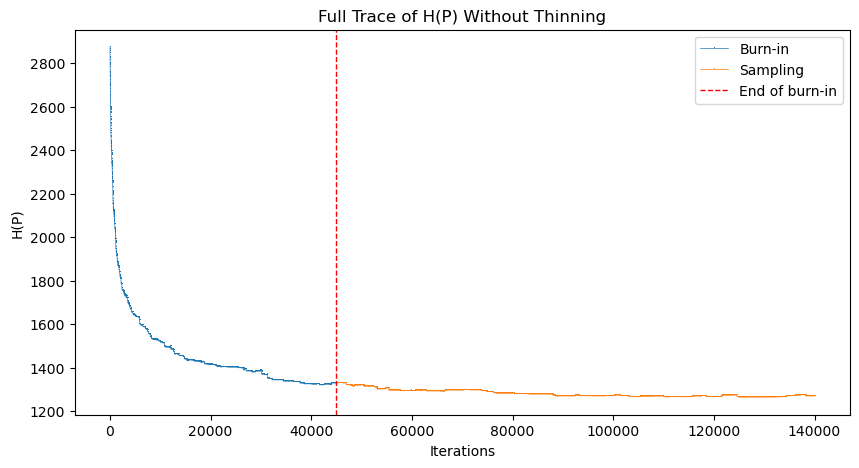

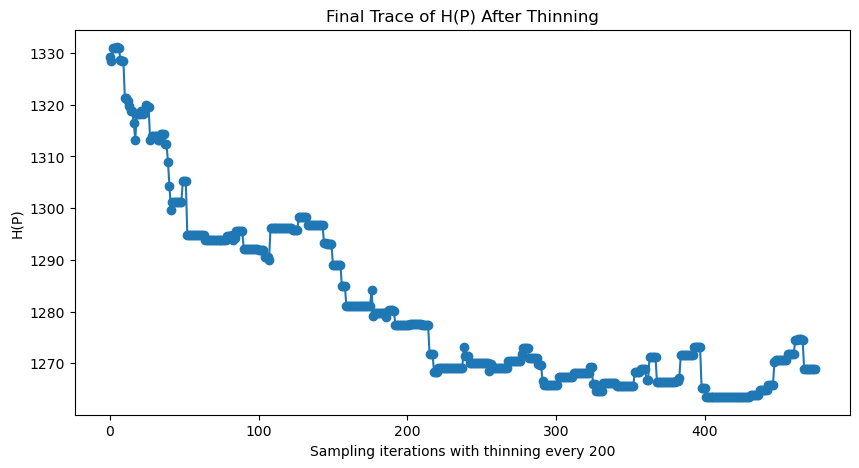

In [12]:
# Perform MCMC sampling on the observed network partitions, collecting the trace of H(P)
partitions, H_burn_in, H_full_trace = mcmc_trace_H(G_obs, equilibration=45000, num_samples=95000)

# Plot the H(P) trace
plot_H_trace(H_burn_in, H_full_trace)


thinning_interval = 200

# Apply thinning to H(P) samples
H_final = H_full_trace[::thinning_interval]
# Apply thinning to partitions to obtain independent samples
partitions_thinned = partitions[::thinning_interval]

# Call the function to plot the final trace of H(P)
plot_final_H_trace(H_final, thinning_interval)

In [13]:
### DEBUGGING
# Subito dopo aver calcolato H_final
print("H_values (H_final) - min:", min(H_final), "max:", max(H_final))
print("H_values (H_final) - primi 10 valori:", H_final[:10])
print("H_values (H_final) - ultimi 10 valori:", H_final[-10:])
print("H_values (H_final) - std:", np.std(H_final))

H_values (H_final) - min: 1263.439635945069 max: 1331.1356926175201
H_values (H_final) - primi 10 valori: [1329.257431139582, 1328.39045359887, 1330.9430423118506, 1330.9430423118506, 1330.9430423118506, 1331.1356926175201, 1331.0513428649344, 1328.5703362595564, 1328.5427156501319, 1328.5427156501319]
H_values (H_final) - ultimi 10 valori: [1274.7100178169135, 1274.4570427541678, 1268.8734588761108, 1268.8734588761108, 1268.8734588761108, 1268.8734588761108, 1268.8734588761108, 1268.8734588761108, 1268.8734588761108, 1268.8734588761108]
H_values (H_final) - std: 16.712293595945734


In [14]:
### DEBUGGING
from collections import Counter
# Analizza la dimensione dei gruppi per le prime 5 partizioni
for idx, P in enumerate(partitions_thinned[:5]):
    group_sizes = Counter(P.values())
    print(f"Partizione {idx}: {len(group_sizes)} gruppi, dimensioni gruppi: {sorted(group_sizes.values(), reverse=True)}")

Partizione 0: 14 gruppi, dimensioni gruppi: [12, 12, 11, 10, 9, 9, 9, 7, 6, 6, 4, 2, 2, 1]
Partizione 1: 15 gruppi, dimensioni gruppi: [13, 12, 11, 10, 9, 9, 8, 7, 6, 6, 4, 2, 1, 1, 1]
Partizione 2: 15 gruppi, dimensioni gruppi: [12, 12, 11, 10, 9, 9, 8, 7, 6, 6, 4, 3, 1, 1, 1]
Partizione 3: 15 gruppi, dimensioni gruppi: [12, 12, 11, 10, 9, 9, 8, 7, 6, 6, 4, 3, 1, 1, 1]
Partizione 4: 15 gruppi, dimensioni gruppi: [12, 12, 11, 10, 9, 9, 8, 7, 6, 6, 4, 3, 1, 1, 1]


C:\Users\eugen\AppData\Local\Temp\ipykernel_21184\3441655393.py:22: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)


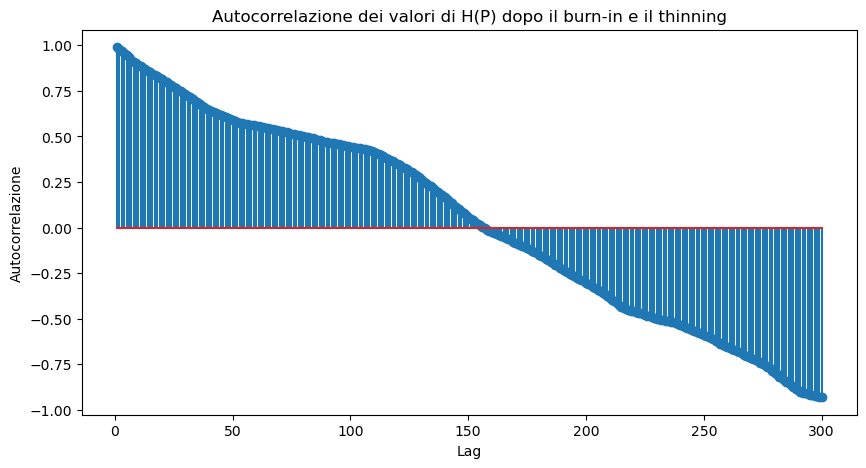

In [15]:
##### Poi questo lo togliamo, è solo per vedere come va l'autocorrelazione - RIFARE

def autocorrelation(series, max_lag):
    """ Calcola l'autocorrelazione per una serie di valori fino a max_lag. """
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    autocorrs = []

    for lag in range(1, max_lag + 1):
        ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
        autocorrs.append(ct / c0)

    return autocorrs

# Calcoliamo l'autocorrelazione per i valori di H(P) del burn-in
max_lag = 300  # Puoi variare questo valore per vedere fino a dove l'autocorrelazione decade
autocorr_values = autocorrelation(H_final, max_lag)

# Plottiamo la funzione di autocorrelazione
plt.figure(figsize=(10, 5))
plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.title("Autocorrelazione dei valori di H(P) dopo il burn-in e il thinning")
plt.show()


## 2 Compute the reliabilities

### 2.1 Link Reliability

This section introduces the function *estimate_link_reliability*, which calculates the link reliability $RL_{ij}$ for each node pair $(i,j)$ in a network, following a probabilistic formulation.

- The function iterates over a set of sampled partitions and computes the probability of a link existing between nodes, based on observed and expected connections.

- It uses the entropy function $H(P)$ to weigh partitions, ensuring statistically significant estimates.

- The result provides a normalized reliability score, which helps infer missing or uncertain links in noisy network data.

This method is useful for network reconstruction, link prediction, and structural analysis under uncertainty.

In [16]:
def estimate_link_reliability(G, partitions, H_values):
    """
    Estimates link reliability RL_ij for each pair (i, j) where i < j,
    using the formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Initialize dictionary for RL for all pairs (i, j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            reliability[(i, j)] = 0.0

     # Find the maximum H(P) value to compute c
    c = max(H_values)
    
    Z = 0.0  # Normalization factor
    
    for P, H_P in zip(partitions, H_values):
        weight = np.exp(-H_P + c)  # Adjusted weight with normalization constant c
        Z += weight
        
        # Group nodes by block for partition P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Precompute r and lO for each pair of blocks in partition P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # For identical blocks
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Count observed links within the block
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # For different block pairs
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Apply formula for each node pair (i, j) based on groups in P
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # If no observed links exist, lO defaults to 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # Avoid division by zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalize results
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

In [17]:
# Estimate link reliability for each node pair in the observed network
RL = estimate_link_reliability(G_obs, partitions_thinned, H_final)

# Print some results (e.g., for the first 10 pairs)
print("Link Reliability for selected node pairs:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Pair {key}: RL = {RL[key]:.4f}")


Link Reliability for selected node pairs:
Pair (0, 1): RL = 0.0507
Pair (0, 2): RL = 0.0507
Pair (0, 3): RL = 0.0136
Pair (0, 4): RL = 0.0507
Pair (0, 5): RL = 0.0507
Pair (0, 6): RL = 0.0275
Pair (0, 7): RL = 0.0507
Pair (0, 8): RL = 0.0507
Pair (0, 9): RL = 0.0135
Pair (0, 10): RL = 0.0166
Pair (0, 11): RL = 0.0136
Pair (0, 12): RL = 0.0135
Pair (0, 13): RL = 0.0135
Pair (0, 14): RL = 0.0135
Pair (0, 15): RL = 0.0276
Pair (0, 16): RL = 0.0518
Pair (0, 17): RL = 0.0501
Pair (0, 18): RL = 0.0168
Pair (0, 19): RL = 0.0518
Pair (0, 20): RL = 0.0160
Pair (0, 21): RL = 0.0253
Pair (0, 22): RL = 0.0518
Pair (0, 23): RL = 0.0253
Pair (0, 24): RL = 0.0324
Pair (0, 25): RL = 0.0136
Pair (0, 26): RL = 0.0253
Pair (0, 27): RL = 0.0165
Pair (0, 28): RL = 0.0325
Pair (0, 29): RL = 0.0136
Pair (0, 30): RL = 0.0325
Pair (0, 31): RL = 0.0159
Pair (0, 32): RL = 0.0400
Pair (0, 33): RL = 0.0518
Pair (0, 34): RL = 0.0253
Pair (0, 35): RL = 0.0256
Pair (0, 36): RL = 0.0159
Pair (0, 37): RL = 0.0400
Pair 

RL min: 0.0109, RL max: 0.8382, RL mean: 0.1535, RL std: 0.2259


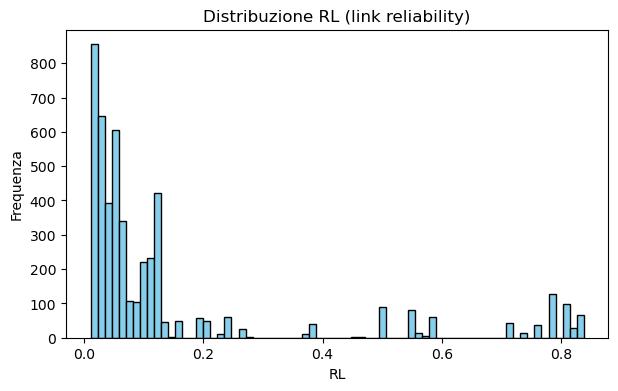

In [18]:
### PER DEBUGGING
RL_values = np.array(list(RL.values()))
print(f"RL min: {RL_values.min():.4f}, RL max: {RL_values.max():.4f}, RL mean: {RL_values.mean():.4f}, RL std: {RL_values.std():.4f}")

plt.figure(figsize=(7,4))
plt.hist(RL_values, bins=70, color='skyblue', edgecolor='black')
plt.title("Distribuzione RL (link reliability)")
plt.xlabel("RL")
plt.ylabel("Frequenza")
plt.show()

#### 2.1.1 Ranking Probability for Missing and Spurious Interactions in Networks

In [19]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false negative (AO=0, AT=1) has a higher RL
    than a true negative (AO=0, AT=0).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Build lists of node pairs based on definitions
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # If there are no examples, return None or 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # For each pair, add 1 if the false negative has a higher RL than the true negative,
    # 0.5 if they are equal.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability


def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false positive (AO=1, AT=0) has a lower RL
    than a true positive (AO=1, AT=1).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Here we want the false positive to have a lower RL than the true positive,
    # meaning in descending order the true positive should come first.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability




In [20]:
# Compute the probability for missing interactions (false negatives)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probability that a false negative has a higher RL than a true negative: {p_missing:.4f}")
else:
    print("Not enough examples for missing interactions.")
    
# Compute the probability for spurious interactions (false positives)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probability that a false positive has a lower RL than a true positive: {p_spurious:.4f}")
else:
    print("Not enough examples for spurious interactions.")

Probability that a false negative has a higher RL than a true negative: 0.9306
Probability that a false positive has a lower RL than a true positive: 0.9258


Missing interactions:
La probabilità che un false negative (un link che esiste nella rete vera ma manca nella rete osservata) abbia una reliability RL maggiore di un true negative (un link che non esiste né nella vera né nell’osservata).

Spurious interactions:
La probabilità che un false positive (un link spurio, cioè presente solo nella rete osservata) abbia una RL minore di un true positive (un link vero, cioè presente sia nella vera che nell’osservata).

Cosa significa un valore vicino a 1?
Se la probabilità è vicina a 1 (come 0.92 o 0.94), significa che:
Quasi sempre il tuo metodo assegna una reliability più alta ai link che dovrebbero esserci (missing) rispetto a quelli che non dovrebbero esserci (true negative).
Quasi sempre assegna una reliability più bassa ai link spurii rispetto ai veri positivi.
In altre parole:
Il tuo metodo è molto bravo a distinguere tra link veri e link falsi!
Se la probabilità fosse 0.5, significherebbe che il metodo non distingue (è come tirare a caso).
Se fosse < 0.5, significherebbe che il metodo sbaglia sistematicamente.

Perché è desiderabile?
Valori alti sono desiderabili: vuoi che i link veri siano sempre più affidabili (RL alta) dei link falsi.
Il tuo metodo funziona bene: i link che mancano per errore vengono comunque riconosciuti come "probabili" e i link spurii vengono riconosciuti come "improbabili".

#### 2.1.2 Accuracy of Missing and Spurious Interactions in Network Reconstruction

1. La cella va bene?
La cella sembra corretta nel calcolo delle accuratezze per le interazioni mancanti e spurie. Tuttavia, ci sono alcuni aspetti che potrebbero essere migliorati per evitare problemi di stabilità numerica e ottimizzare i calcoli.

2. Ci sono loop?
Sì, ci sono diversi loop annidati:

Loop sui nodi e sugli archi: Durante il calcolo di rank_probability_missing_interactions e rank_probability_spurious_interactions, vengono iterati tutti i nodi e gli archi per classificare le interazioni.
Loop sui campioni MCMC: Durante il calcolo di RL_missing e RL_spurious, vengono iterati tutti i campioni delle partizioni e i valori di entropia.
Questi loop possono diventare costosi per reti grandi o per un numero elevato di campioni MCMC. Se il calcolo è lento, potresti considerare l'ottimizzazione tramite vectorization o l'uso di librerie come NumPy.

3. Problemi nel calcolo dell'esponenziale di H
Il problema dell'esponenziale di H può verificarsi se i valori di H(P) sono molto grandi, causando un overflow numerico. Questo problema è mitigato nel tuo codice con l'uso di una costante di normalizzazione c:

Tuttavia, se H(P) varia molto tra i campioni, potresti comunque avere problemi di stabilità numerica. Per risolvere definitivamente:

Assicurati che c = max(H_values) sia calcolato correttamente.
Se i problemi persistono, considera di lavorare direttamente con i logaritmi per evitare il calcolo esplicito dell'esponenziale.
4. Quale traccia di H usare per RL_missing e RL_spurious?
Dipende da quale parte della catena vuoi utilizzare:

Se usi tutta la catena dopo il burn-in (senza thinning): Usa H_full_trace_missing e H_full_trace_spurious.
Se applichi il thinning per ridurre la correlazione tra i campioni: Usa H_final_missing e H_final_spurious, che sono versioni ridotte di H_full_trace dopo il thinning.
Esempio per il thinning:

Consiglio: Usa sempre la versione "thinned" (H_final_*) per garantire che i campioni siano indipendenti e ridurre il costo computazionale.

5. Suggerimenti per migliorare il codice
Ottimizzazione dei loop: Se possibile, usa librerie come NumPy per calcoli vettorializzati.
Stabilità numerica: Lavora con i logaritmi per evitare problemi di overflow.
Thinning: Usa sempre i campioni "thinned" per calcoli più efficienti e robusti.

In [21]:
def autocorrelation(series, lag):
    """
    Calcola il coefficiente di autocorrelazione per una data serie e un lag specifico.
    """
    n = len(series)
    if lag >= n:
        return 0
    series = np.array(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
    return ct / c0


def estimate_autocorrelation_time(series, max_lag=None, threshold=0.05):
    """
    Stima il tempo integrato di autocorrelazione (tau_int) della serie.
    
    :param series: Serie temporale (lista o array) dei valori campionati (ad es. H(P)).
    :param max_lag: lag massimo per il quale calcolare l'autocorrelazione. Se None, si usa len(series)//2.
    :param threshold: opzione per interrompere la somma quando l'autocorrelazione scende al di sotto di questo valore.
    :return: tau_int, il tempo integrato di autocorrelazione.
    """
    n = len(series)
    if max_lag is None:
        max_lag = n // 2

    tau_int = 1.0  # include t=0, per cui rho(0)=1
    acfs = [1.0]  # autocorrelazione al lag 0 è 1
    for lag in range(1, max_lag):
        rho = autocorrelation(series, lag)
        acfs.append(rho)
        # Se l'autocorrelazione è inferiore al threshold, possiamo interrompere la somma
        if rho < threshold:
            break
    # Somma dei termini (moltiplicati per 2, come nella formula comune)
    tau_int += 2 * np.sum(acfs[1:])
    return tau_int, acfs

In [22]:
# POI TOLGO FATTO ALLA FINE

def calculate_accuracies(G_true, error_fractions, num_samples=1000, equilibration=1000):
    accuracy_missing = []
    accuracy_spurious = []

    for f in error_fractions:
        # --- MISSING ---
        G_obs_missing = G_true.copy()
        edges = list(G_true.edges())
        num_remove = int(len(edges) * f)
        if num_remove > 0:
            remove_indices = np.random.choice(len(edges), num_remove, replace=False)
            for idx in remove_indices:
                G_obs_missing.remove_edge(*edges[idx])
        # MCMC + thinning
        parts, _, H_trace = mcmc_trace_H(G_obs_missing, equilibration, num_samples)
        thinning = max(1, int(estimate_autocorrelation_time(H_trace)[0]))
        H_final = H_trace[::thinning]
        parts_final = parts[::thinning]
        RL = estimate_link_reliability(G_obs_missing, parts_final, H_final)
        p_missing = rank_probability_missing_interactions(G_true, G_obs_missing, RL)
        accuracy_missing.append(1.0 if p_missing is None else p_missing)

        # --- SPURIOUS ---
        G_obs_spurious = G_true.copy()
        non_edges = list(nx.non_edges(G_true))
        num_add = int(len(edges) * f)
        if num_add > 0:
            add_indices = np.random.choice(len(non_edges), num_add, replace=False)
            for idx in add_indices:
                G_obs_spurious.add_edge(*non_edges[idx])
        # MCMC + thinning
        parts, _, H_trace = mcmc_trace_H(G_obs_spurious, equilibration, num_samples)
        thinning = max(1, int(estimate_autocorrelation_time(H_trace)[0]))
        H_final = H_trace[::thinning]
        parts_final = parts[::thinning]
        RL = estimate_link_reliability(G_obs_spurious, parts_final, H_final)
        p_spurious = rank_probability_spurious_interactions(G_true, G_obs_spurious, RL)
        accuracy_spurious.append(1.0 if p_spurious is None else p_spurious)

    return accuracy_missing, accuracy_spurious




In [23]:
#POI TOGLO FATTO ALLA FINE
run_accuracies = False  # CHANGE THIS VALUE TO TRUE TO RUN THE ACCURACIES

if run_accuracies:
    error_fractions = np.linspace(0.05, 0.8, 6)
    accuracy_missing, accuracy_spurious = calculate_accuracies(
        G_true, error_fractions, num_samples=75000, equilibration=37000
    )
    plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious)

### 2.2 Network reliability   -  <span style="color: RED;"> DA QUI IN POI SISTEMARE</span>

 our approach is
remarkably able to identify that AT is a more likely network than
the observation AO itself. This confirms that, even without know-
ing A T , it is possible to estimate a property X (AT ) better than just
by measuring that property on AO (that is, better than assuming
X (AT ) = X (AO)).

In [24]:
### per verificare se tutto va bene
RL_values = list(RL.values())
print(f"RL min: {min(RL_values):.4f}, RL max: {max(RL_values):.4f}")

# Se vuoi vedere i 10 più alti e 10 più bassi:
print("Top 10 RL:", sorted(RL_values, reverse=True)[:10])
print("Bottom 10 RL:", sorted(RL_values)[:10])

RL min: 0.0109, RL max: 0.8382
Top 10 RL: [0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479, 0.8382352941176479]
Bottom 10 RL: [0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813, 0.010920800262925813]


In [25]:
def compute_network_reliability(G_candidate, G_obs, partitions, H_values):
    """
    Calcola la network reliability RN_A per una rete candidata G_candidate
    rispetto all'osservazione G_obs, usando le partizioni e H_values campionate.
    """
    nodes = list(G_candidate.nodes())
    A = nx.to_numpy_array(G_candidate)
    AO = nx.to_numpy_array(G_obs)
    c = max(H_values)
    Z = 0.0
    RN_A = 0.0

    h_list = []
    for P, H_P in zip(partitions, H_values):
        # Raggruppa i nodi per blocco
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        groups = list(block_nodes.keys())

        # Precalcola r, lO (su AO), l (su A candidata)
        r = {}
        lO = {}
        l = {}
        for g1 in groups:
            for g2 in groups:
                key = tuple(sorted([g1, g2]))
                if key not in r:
                    if g1 == g2:
                        n = len(block_nodes[g1])
                        r[key] = n * (n - 1) // 2
                        lO[key] = np.sum(AO[np.ix_(block_nodes[g1], block_nodes[g2])]) // 2
                        l[key] = np.sum(A[np.ix_(block_nodes[g1], block_nodes[g2])]) // 2
                    else:
                        n1 = len(block_nodes[g1])
                        n2 = len(block_nodes[g2])
                        r[key] = n1 * n2
                        lO[key] = np.sum(AO[np.ix_(block_nodes[g1], block_nodes[g2])])
                        l[key] = np.sum(A[np.ix_(block_nodes[g1], block_nodes[g2])])

        # Calcola h(A; AO, P)
        h = 0.0
        for key in r:
            r_ab = r[key]
            lO_ab = int(lO[key])
            l_ab = int(l[key])
            # Termini combinatoriali (usa log-gamma per stabilità numerica)
            try:
                log_comb1 = math.lgamma(r_ab + 1) - math.lgamma(lO_ab + 1) - math.lgamma(r_ab - lO_ab + 1)
                log_comb2 = math.lgamma(2 * r_ab + 1) - math.lgamma(l_ab + lO_ab + 1) - math.lgamma(2 * r_ab - l_ab - lO_ab + 1)
            except ValueError:
                log_comb1 = 0
                log_comb2 = 0
            h += np.log((r_ab + 1) / (2 * r_ab + 1)) + (log_comb1 - log_comb2)
        h_list.append(h)

    print(f"h_list (primi 5): {h_list[:5]}")
    h_max = max(h_list)
    # Ora somma pesata normalizzata
    for h, H_P in zip(h_list, H_values):
        weight = np.exp(-H_P + c)
        RN_A += np.exp(h - h_max) * weight
        Z += weight

    return RN_A / Z if Z > 0 else 0



Se vedi che h è sempre molto negativo (tipo -700 o meno), allora np.exp(h) sarà praticamente zero per limiti numerici di Python.

In [26]:
def reconstruct_network(G_obs, partitions, H_values, RL, max_rejects=30):
    """
    Ricostruisce la rete AR massimizzando RN_A secondo la procedura euristica dell'articolo.
    """
    G_rec = G_obs.copy()
    nodes = list(G_obs.nodes())
    # Lista archi e non-archi con RL
    edges = [(i, j) for i, j in G_obs.edges() if i < j]
    non_edges = [(i, j) for i in range(len(nodes)) for j in range(i+1, len(nodes)) if not G_obs.has_edge(i, j)]
    # Ordina archi osservati per RL crescente (meno affidabili)
    edges_sorted = sorted(edges, key=lambda x: RL.get(x, 0))
    # Ordina non-archi per RL decrescente (più affidabili)
    non_edges_sorted = sorted(non_edges, key=lambda x: RL.get(x, 0), reverse=True)

    swap_count = 0

    while True:
        rejects = 0
        idx_edge = 0
        idx_nonedge = 0
        best_RN = compute_network_reliability(G_rec, G_obs, partitions, H_values)
        improved = False

        while rejects < max_rejects and idx_edge < len(edges_sorted) and idx_nonedge < len(non_edges_sorted):
            u, v = edges_sorted[idx_edge]
            x, y = non_edges_sorted[idx_nonedge]
            # Crea una copia candidata
            G_candidate = G_rec.copy()
            G_candidate.remove_edge(u, v)
            G_candidate.add_edge(x, y)
            RN_candidate = compute_network_reliability(G_candidate, G_obs, partitions, H_values)
            # STAMPA I VALORI DI RN_A (debugging)
            print(f"RN prima dello swap: {best_RN:.6f}, RN dopo swap ({u},{v}) -> ({x},{y}): {RN_candidate:.6f}")

            if RN_candidate > best_RN:
                # Accetta lo swap
                print(f"Swap accettato: ({u},{v}) -> ({x},{y})")
                G_rec = G_candidate
                best_RN = RN_candidate
                improved = True
                swap_count += 1
                break  # Dopo ogni accettazione, si ricalcolano RL e si riparte
            else:
                rejects += 1
            idx_edge += 1
            idx_nonedge += 1

        if not improved:
            break  # Nessuno swap accettato, termina
        # Ricalcola RL sulle nuove G_rec (opzionale)
        RL = estimate_link_reliability(G_rec, partitions, H_values)
        # Aggiorna le liste ordinate
        edges = [(i, j) for i, j in G_rec.edges() if i < j]
        non_edges = [(i, j) for i in range(len(nodes)) for j in range(i+1, len(nodes)) if not G_rec.has_edge(i, j)]
        edges_sorted = sorted(edges, key=lambda x: RL.get(x, 0))
        non_edges_sorted = sorted(non_edges, key=lambda x: RL.get(x, 0), reverse=True)
        print(f"edges_sorted: {len(edges_sorted)} elementi, non_edges_sorted: {len(non_edges_sorted)} elementi")
        if not edges_sorted:
            print("ATTENZIONE: edges_sorted è vuoto!")
        if not non_edges_sorted:
            print("ATTENZIONE: non_edges_sorted è vuoto!")

    print(f"Numero totale di swap ACCEPTED: {swap_count}")
    return G_rec

Fare lo swap nella tua funzione di ricostruzione della rete significa:

Togliere un arco (link) poco affidabile dalla rete osservata (cioè un collegamento che secondo la stima RL è poco probabile che esista nella rete vera).
Aggiungere un nuovo arco tra due nodi che nella rete osservata non sono collegati, ma che secondo RL sarebbe più probabile che esistano nella rete vera.
In pratica:

Prendi un arco (u, v) con RL bassa (meno affidabile) e lo rimuovi.
Prendi una coppia di nodi (x, y) senza arco, ma con RL alta (più affidabile), e aggiungi l’arco tra loro.
Valuti se questa nuova rete (dopo lo swap) ha una network reliability RN_A maggiore.
Se sì, accetti lo swap (cioè tieni la modifica); altrimenti la scarti.
Scopo:
Migliorare la rete osservata, rendendola più simile a quella vera secondo la funzione di reliability, sostituendo archi "sospetti" con archi "probabili".

Riassunto:
Lo swap = scambio tra un arco poco affidabile e uno più affidabile, per avvicinarsi alla rete vera.

print(f"RN prima dello swap: {best_RN:.6f}, RN dopo swap ({u},{v}) -> ({x},{y}): {RN_candidate:.6f}")  
Questa stampa ti mostra, per ogni tentativo di swap, il valore di RN_A prima e dopo.
Se vedi sempre valori identici, significa che lo swap non cambia la network reliability

In [27]:
# Dopo aver calcolato RL, partitions_thinned, H_final:
G_reconstructed = reconstruct_network(G_obs, partitions_thinned, H_final, RL)

h_list (primi 5): [-1191.6524476472134, -1169.3039443178056, -1171.36368492417, -1171.36368492417, -1171.36368492417]
h_list (primi 5): [-1184.7545912004105, -1162.5246476057273, -1164.5843882120917, -1164.5843882120917, -1164.5843882120917]
RN prima dello swap: 0.000035, RN dopo swap (65,81) -> (2,4): 0.000035
h_list (primi 5): [-1184.6486097595541, -1162.4185880337668, -1164.4783286401312, -1164.4783286401312, -1164.4783286401312]
RN prima dello swap: 0.000035, RN dopo swap (61,80) -> (2,56): 0.000035
h_list (primi 5): [-1184.7545912004105, -1162.5246476057273, -1164.5843882120917, -1164.5843882120917, -1164.5843882120917]
RN prima dello swap: 0.000035, RN dopo swap (12,73) -> (2,57): 0.000035
h_list (primi 5): [-1185.0568720722833, -1162.7083687428756, -1164.7681093492401, -1164.7681093492401, -1164.7681093492401]
RN prima dello swap: 0.000035, RN dopo swap (70,91) -> (4,8): 0.000032
h_list (primi 5): [-1184.7180017529781, -1162.3694984235706, -1164.429239029935, -1164.429239029935,

Cosa aspettarsi in pratica
In reti realistiche (e con RL ben calcolato): di solito vengono accettati pochi swap (da 1 a 10), perché la funzione RN_A è spesso piatta o cambia poco tra reti simili.
Se nessuno swap viene accettato: può essere normale se la rete osservata è già "buona", oppure può indicare che RN_A è troppo piatta o RL poco informativo.
Se ne accetta tanti (decine): probabilmente la rete osservata è molto rumorosa o RL è molto discriminante.

##### **SPIEGAZIONE**
Cos’è lo swap nella ricostruzione della rete?
Swap = scambiare un arco poco affidabile con uno più affidabile:

Togli un arco (u, v) dalla rete osservata (G_obs) che ha RL (link reliability) bassa (cioè è poco probabile che sia un vero arco).
Aggiungi un arco (x, y) che non è presente in G_obs ma che ha RL alta (cioè è probabile che sia un vero arco).
Dopo lo swap, calcoli RN_A (network reliability) della nuova rete candidata.
Accetti lo swap solo se RN_A aumenta (cioè la nuova rete è più probabile secondo il modello).
Quando avviene lo swap?
Prendi la lista degli archi osservati ordinati per RL crescente (meno affidabili).
Prendi la lista dei non-archi ordinati per RL decrescente (più affidabili).
Provi a scambiare il meno affidabile con il più affidabile.
Lo swap avviene solo se la nuova rete ha RN_A > RN_A della rete corrente.
Cosa devono essere RL e RN per accettare uno swap?
RL serve solo per scegliere quali archi togliere e aggiungere (non per accettare lo swap).
RN_A è il criterio di accettazione:
Se RN_A (dopo lo swap) > RN_A (prima dello swap) → accetti lo swap.
Altrimenti, lo scarti e passi al prossimo tentativo.
Il ciclo si ferma dopo max_rejects swap consecutivi non accettati.
Perché non vedi miglioramento?
Se il miglioramento finale è 0.0% e la rete ricostruita è uguale a quella osservata, può essere per diversi motivi:

RL non distingue bene tra archi veri e falsi
Se la stima di RL è piatta o poco informativa, gli swap non portano a reti più probabili.

La funzione RN_A è piatta
Se RN_A cambia poco tra reti simili, nessuno swap viene accettato.

max_rejects troppo alto o troppo basso
Con 50 tentativi, il ciclo dovrebbe esplorare abbastanza, ma se nessuno swap migliora RN_A, il problema è altrove.

Problemi numerici
Se RN_A è sempre quasi uguale (es. differenze minime per limiti numerici), il codice non accetta mai swap.

Campionamento MCMC non efficace
Se le partizioni usate per RL e RN_A non sono rappresentative, la ricostruzione non funziona.

Cosa puoi controllare?
Stampa RN_A prima e dopo ogni swap: vedi se cambia anche di poco.
Stampa RL degli archi candidati: vedi se c’è davvero differenza tra i più bassi e i più alti.
Prova a ridurre max_rejects a 5 come nell’articolo, ma se già con 50 non cambia nulla, il problema è altrove.
Controlla che RL abbia una buona varianza (non tutti uguali).
Controlla che la funzione di ricostruzione aggiorni davvero la rete (cioè che almeno qualche swap venga accettato).
In sintesi
Lo swap avviene solo se RN_A aumenta.
RL serve solo per scegliere cosa togliere/mettere.
Se non vedi miglioramento, probabilmente nessuno swap migliora RN_A:
O RL non è informativo
O RN_A è troppo piatta
O c’è un bug nella logica di accettazione

#### 2.2.1 Analisi fatta da me per vedere i risultati


Visualizza la rete ricostruita con una funzione di plot (come già fatto per la rete osservata e quella vera).

(i) missing links in orange, which exist in the true
network but not in the observation (reconstruction) and (ii) spurious links
in blue, which do not exist in the true network but do exist in the obser-
vation (reconstruction).

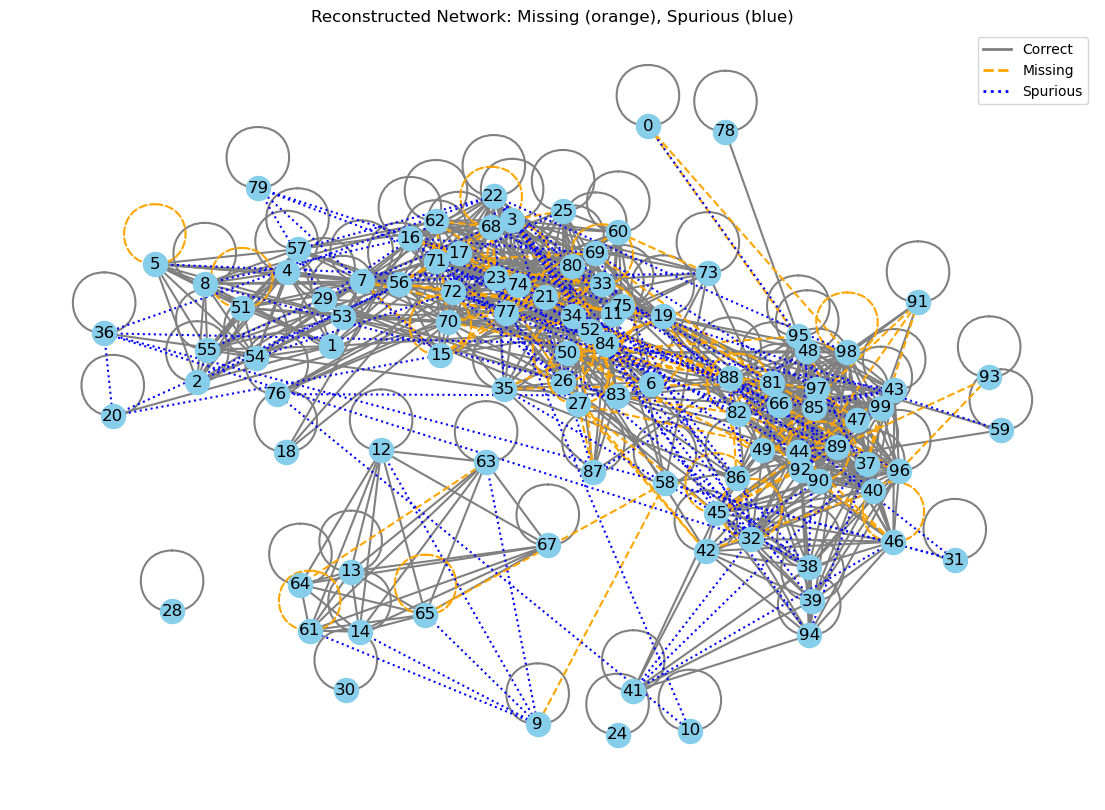

In [28]:
def plot_reconstruction_diff(G_true, G_rec, title="Reconstructed Network: Missing (orange), Spurious (blue)"):
    """
    Plotta la rete ricostruita evidenziando:
    - missing links (presenti in G_true ma non in G_rec) in arancione
    - spurious links (presenti in G_rec ma non in G_true) in blu
    - altri link in grigio
    """
    pos = nx.spring_layout(G_true, k=0.7, seed=42)
    # Trova missing e spurious
    true_edges = set(tuple(sorted(e)) for e in G_true.edges())
    rec_edges = set(tuple(sorted(e)) for e in G_rec.edges())
    missing = true_edges - rec_edges
    spurious = rec_edges - true_edges
    common = true_edges & rec_edges

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G_true, pos, node_color='skyblue', node_size=300)
    nx.draw_networkx_labels(G_true, pos, font_color='black')

    # Archi comuni in grigio
    nx.draw_networkx_edges(G_true, pos, edgelist=list(common), edge_color='gray', width=1.5)
    # Missing in arancione
    nx.draw_networkx_edges(G_true, pos, edgelist=list(missing), edge_color='orange', width=1.5, style='dashed', label='Missing')
    # Spurious in blu
    nx.draw_networkx_edges(G_true, pos, edgelist=list(spurious), edge_color='blue', width=1.5, style='dotted', label='Spurious')

    plt.title(title)
    plt.axis('off')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='gray', lw=2, label='Correct'),
        plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='Missing'),
        plt.Line2D([0], [0], color='blue', lw=2, linestyle=':', label='Spurious')
    ])
    plt.show()

# Esempio di chiamata:
plot_reconstruction_diff(G_true, G_reconstructed)

In [29]:
def reconstruction_error_metrics(G_true, G_obs, G_rec):
    """
    Calcola il numero di missing e spurious links per G_obs e G_rec,
    e la percentuale di miglioramento della ricostruzione rispetto all'osservazione.
    """
    # Set di archi (non orientati)
    true_edges = set(tuple(sorted(e)) for e in G_true.edges())
    obs_edges = set(tuple(sorted(e)) for e in G_obs.edges())
    rec_edges = set(tuple(sorted(e)) for e in G_rec.edges())

    # Missing: presenti in G_true ma non in G_X
    missing_obs = true_edges - obs_edges
    missing_rec = true_edges - rec_edges

    # Spurious: presenti in G_X ma non in G_true
    spurious_obs = obs_edges - true_edges
    spurious_rec = rec_edges - true_edges

    # Miglioramento percentuale
    perc_impr_missing = 100 * (len(missing_obs) - len(missing_rec)) / len(missing_obs) if len(missing_obs) > 0 else 0
    perc_impr_spurious = 100 * (len(spurious_obs) - len(spurious_rec)) / len(spurious_obs) if len(spurious_obs) > 0 else 0

    results = {
        "missing_obs": len(missing_obs),
        "missing_rec": len(missing_rec),
        "spurious_obs": len(spurious_obs),
        "spurious_rec": len(spurious_rec),
        "perc_impr_missing": perc_impr_missing,
        "perc_impr_spurious": perc_impr_spurious
    }
    return results

# Esempio di utilizzo:
metrics = reconstruction_error_metrics(G_true, G_obs, G_reconstructed)
print(f"Missing links - Observed: {metrics['missing_obs']}, Reconstructed: {metrics['missing_rec']} ({metrics['perc_impr_missing']:.1f}% improvement)")
print(f"Spurious links - Observed: {metrics['spurious_obs']}, Reconstructed: {metrics['spurious_rec']} ({metrics['perc_impr_spurious']:.1f}% improvement)")

Missing links - Observed: 118, Reconstructed: 93 (21.2% improvement)
Spurious links - Observed: 105, Reconstructed: 80 (23.8% improvement)


In [30]:
#### PER CALCOLARE IN PERCENTUALE QUANTO G_REC è UGUALE A G_TRUE
def percent_difference_edges(G_true, G_rec):
    """
    Calcola la percentuale di archi diversi tra la rete vera e quella ricostruita.
    """
    true_edges = set(tuple(sorted(e)) for e in G_true.edges())
    rec_edges = set(tuple(sorted(e)) for e in G_rec.edges())
    # Archi diversi: presenti solo in una delle due reti
    diff_edges = true_edges.symmetric_difference(rec_edges)
    # Percentuale rispetto al numero di archi della rete vera
    perc_diff = 100 * len(diff_edges) / len(true_edges) if len(true_edges) > 0 else 0
    print(f"Archi diversi (missing + spurii): {len(diff_edges)} su {len(true_edges)} archi veri ({perc_diff:.1f}%)")
    return perc_diff


print("Differenza tra rete vera e rete osservata:")
percent_difference_edges(G_true, G_obs)

print("Differenza tra rete vera e rete ricostruita:")
percent_difference_edges(G_true, G_reconstructed)

Differenza tra rete vera e rete osservata:
Archi diversi (missing + spurii): 223 su 805 archi veri (27.7%)
Differenza tra rete vera e rete ricostruita:
Archi diversi (missing + spurii): 173 su 805 archi veri (21.5%)


21.490683229813666

Calcola e confronta alcune proprietà di rete (clustering, modularità, assortatività, max betweenness, synchronizability, spreading threshold) tra G_true, G_obs, G_reconstructed.   **CHIESTO DAL PAPER**

In [31]:
def network_properties(G):
    """
    Calcola le proprietà di rete richieste dal paper:
    - clustering coefficient (media)
    - modularità (usando la partizione di Louvain)
    - assortatività
    - max betweenness centrality (congestabilità)
    - synchronizability (rapporto tra autovalori Laplaciano)
    - spreading threshold (rapporto tra momenti dei gradi)
    """
    import networkx as nx
    import numpy as np
    try:
        import community as community_louvain  
    except ImportError:
        community_louvain = None

    props = {}

    # Clustering coefficient (media)
    props['clustering'] = nx.average_clustering(G)

    # Modularità (Louvain)
    if community_louvain is not None:
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    else:
        # fallback: modularità con greedy_modularity_communities
        from networkx.algorithms.community import greedy_modularity_communities
        comms = list(greedy_modularity_communities(G))
        modularity = nx.algorithms.community.quality.modularity(G, comms)
    props['modularity'] = modularity

    # Assortatività
    props['assortativity'] = nx.degree_assortativity_coefficient(G)

    # Max betweenness centrality (congestabilità)
    betw = nx.betweenness_centrality(G)
    props['max_betweenness'] = max(betw.values()) if betw else 0

    # Synchronizability: rapporto tra max e min autovalore non nullo del Laplaciano
    L = nx.laplacian_matrix(G).todense()
    eigvals = np.linalg.eigvalsh(L)
    eigvals = np.sort(np.real(eigvals))
    # Prendi il più grande e il più piccolo >0
    if len(eigvals) > 2:
        lambda_max = eigvals[-1]
        lambda_min = eigvals[1]  # il primo è sempre zero
        props['synchronizability'] = lambda_max / lambda_min if lambda_min > 0 else np.nan
    else:
        props['synchronizability'] = np.nan

    # Spreading threshold: rapporto tra primo e secondo momento dei gradi
    degrees = np.array([d for n, d in G.degree()])
    k1 = np.mean(degrees)
    k2 = np.mean(degrees ** 2)
    props['spreading_threshold'] = k1 / (k2 - k1) if (k2 - k1) != 0 else np.nan

    return props

##### POI UNIFICO QUESTA FUNZIONE CON QUELLA CHE CALCOLA LE ACCURACIES
# Parametri
error_fractions = np.linspace(0.05, 0.4, 4)  # come nell'articolo
n_repeats = 1  # numero di ripetizioni per ogni livello di errore

# Inizializza array per salvare errori relativi
prop_names = ['clustering', 'modularity', 'assortativity', 'max_betweenness', 'synchronizability', 'spreading_threshold']
relerr_obs_all = {p: [] for p in prop_names}
relerr_rec_all = {p: [] for p in prop_names}

for f in error_fractions:
    relerr_obs_rep = {p: [] for p in prop_names}
    relerr_rec_rep = {p: [] for p in prop_names}
    for rep in range(n_repeats):
        # 1. Genera rete osservata con errore f
        G_obs, _, _ = modify_network(G_true, f)
        # 2. MCMC su G_obs
        partitions, _, H_full_trace = mcmc_trace_H(G_obs, equilibration=10000, num_samples=50000)
        thinning_interval = 150
        H_final = H_full_trace[::thinning_interval]
        partitions_thinned = partitions[::thinning_interval]
        RL = estimate_link_reliability(G_obs, partitions_thinned, H_final)
        # 3. Ricostruisci la rete
        G_rec = reconstruct_network(G_obs, partitions_thinned, H_final, RL, max_rejects=5)
        # 4. Calcola proprietà
        props_true = network_properties(G_true)
        props_obs = network_properties(G_obs)
        props_rec = network_properties(G_rec)
        # 5. Calcola errore relativo per ogni proprietà
        for p in prop_names:
            relerr_obs_rep[p].append((props_obs[p] - props_true[p]) / props_true[p] if props_true[p] != 0 else np.nan)
            relerr_rec_rep[p].append((props_rec[p] - props_true[p]) / props_true[p] if props_true[p] != 0 else np.nan)
    # 6. Salva media e std per ogni proprietà
    for p in prop_names:
        relerr_obs_all[p].append((np.nanmean(relerr_obs_rep[p]), np.nanstd(relerr_obs_rep[p])))
        relerr_rec_all[p].append((np.nanmean(relerr_rec_rep[p]), np.nanstd(relerr_rec_rep[p])))



Plotta i risultati (ad esempio, errore relativo per ogni proprietà).

In [32]:
def calculate_accuracies_and_properties(
    G_true, 
    error_fractions, 
    num_samples=1000, 
    equilibration=1000, 
    n_repeats=1, 
    thinning_auto=True, 
    thinning_interval=150
):
    """
    Calcola accuracies (missing/spurious) e statistiche delle proprietà di rete
    per ogni frazione di errore, con n_repeats ripetizioni per robustezza statistica.
    """
    prop_names = [
        'clustering', 'modularity', 'assortativity', 
        'max_betweenness', 'synchronizability', 'spreading_threshold'
    ]
    relerr_obs_all = {p: [] for p in prop_names}
    relerr_rec_all = {p: [] for p in prop_names}
    accuracy_missing = []
    accuracy_spurious = []

    for f in error_fractions:
        relerr_obs_rep = {p: [] for p in prop_names}
        relerr_rec_rep = {p: [] for p in prop_names}
        acc_missing_rep = []
        acc_spurious_rep = []
        for rep in range(n_repeats):
            # 1. Genera rete osservata con errore f
            G_obs, _, _ = modify_network(G_true, f)
            # 2. MCMC su G_obs
            partitions, _, H_full_trace = mcmc_trace_H(G_obs, equilibration=equilibration, num_samples=num_samples)
            if thinning_auto:
                thinning = max(1, int(estimate_autocorrelation_time(H_full_trace)[0]))
            else:
                thinning = thinning_interval
            H_final = H_full_trace[::thinning]
            partitions_thinned = partitions[::thinning]
            RL = estimate_link_reliability(G_obs, partitions_thinned, H_final)
            # 3. Ricostruisci la rete
            G_rec = reconstruct_network(G_obs, partitions_thinned, H_final, RL, max_rejects=5)
            # 4. Calcola proprietà
            props_true = network_properties(G_true)
            props_obs = network_properties(G_obs)
            props_rec = network_properties(G_rec)
            # 5. Calcola errore relativo per ogni proprietà
            for p in prop_names:
                relerr_obs_rep[p].append((props_obs[p] - props_true[p]) / props_true[p] if props_true[p] != 0 else np.nan)
                relerr_rec_rep[p].append((props_rec[p] - props_true[p]) / props_true[p] if props_true[p] != 0 else np.nan)
            # 6. Calcola accuracies
            p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
            p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
            acc_missing_rep.append(1.0 if p_missing is None else p_missing)
            acc_spurious_rep.append(1.0 if p_spurious is None else p_spurious)
        # 7. Salva media e std per ogni proprietà
        for p in prop_names:
            relerr_obs_all[p].append((np.nanmean(relerr_obs_rep[p]), np.nanstd(relerr_obs_rep[p])))
            relerr_rec_all[p].append((np.nanmean(relerr_rec_rep[p]), np.nanstd(relerr_rec_rep[p])))
        # 8. Salva media accuracies
        accuracy_missing.append((np.mean(acc_missing_rep), np.std(acc_missing_rep)))
        accuracy_spurious.append((np.mean(acc_spurious_rep), np.std(acc_spurious_rep)))

    return relerr_obs_all, relerr_rec_all, accuracy_missing, accuracy_spurious

h_list (primi 5): [-855.4357438010214, -855.4357438010214, -855.8009347142155, -855.8009347142155, -855.8009347142155]
h_list (primi 5): [-846.7588581708718, -846.7588581708718, -847.3029345359473, -847.3029345359473, -847.3029345359473]
RN prima dello swap: 0.000488, RN dopo swap (55,66) -> (37,48): 0.000488
h_list (primi 5): [-846.9600916125503, -846.9600916125503, -847.5042011789844, -847.5042011789844, -847.5042011789844]
RN prima dello swap: 0.000488, RN dopo swap (65,97) -> (37,81): 0.000488
Swap accettato: (65,97) -> (37,81)
edges_sorted: 705 elementi, non_edges_sorted: 4245 elementi
h_list (primi 5): [-846.9600916125503, -846.9600916125503, -847.5042011789844, -847.5042011789844, -847.5042011789844]
h_list (primi 5): [-838.1744841190398, -838.1744841190398, -838.8970454140903, -838.8970454140903, -838.8970454140903]
RN prima dello swap: 0.000488, RN dopo swap (55,66) -> (37,48): 0.000488
h_list (primi 5): [-838.7642981541245, -838.7642981541245, -839.4295521039181, -839.4295521

C:\Users\eugen\AppData\Local\Temp\ipykernel_21184\895571699.py:57: RuntimeWarning: Mean of empty slice
  relerr_obs_all[p].append((np.nanmean(relerr_obs_rep[p]), np.nanstd(relerr_obs_rep[p])))
c:\Users\eugen\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\eugen\AppData\Local\Temp\ipykernel_21184\895571699.py:58: RuntimeWarning: Mean of empty slice
  relerr_rec_all[p].append((np.nanmean(relerr_rec_rep[p]), np.nanstd(relerr_rec_rep[p])))


h_list (primi 5): [-1072.7319682910058, -1072.7319682910058, -1072.7319682910058, -1072.7319682910058, -1061.796926222624]
h_list (primi 5): [-1066.534379197753, -1066.534379197753, -1066.534379197753, -1066.534379197753, -1055.5993371293712]
RN prima dello swap: 0.000026, RN dopo swap (2,61) -> (43,81): 0.000202
Swap accettato: (2,61) -> (43,81)
edges_sorted: 702 elementi, non_edges_sorted: 4248 elementi
h_list (primi 5): [-1066.534379197753, -1066.534379197753, -1066.534379197753, -1066.534379197753, -1055.5993371293712]
h_list (primi 5): [-1060.7438631624725, -1060.7438631624725, -1060.7438631624725, -1060.7438631624725, -1049.8088210940907]
RN prima dello swap: 0.000202, RN dopo swap (73,92) -> (43,82): 0.001499
Swap accettato: (73,92) -> (43,82)
edges_sorted: 702 elementi, non_edges_sorted: 4248 elementi
h_list (primi 5): [-1060.7438631624725, -1060.7438631624725, -1060.7438631624725, -1060.7438631624725, -1049.8088210940907]
h_list (primi 5): [-1056.1705707153824, -1056.170570715

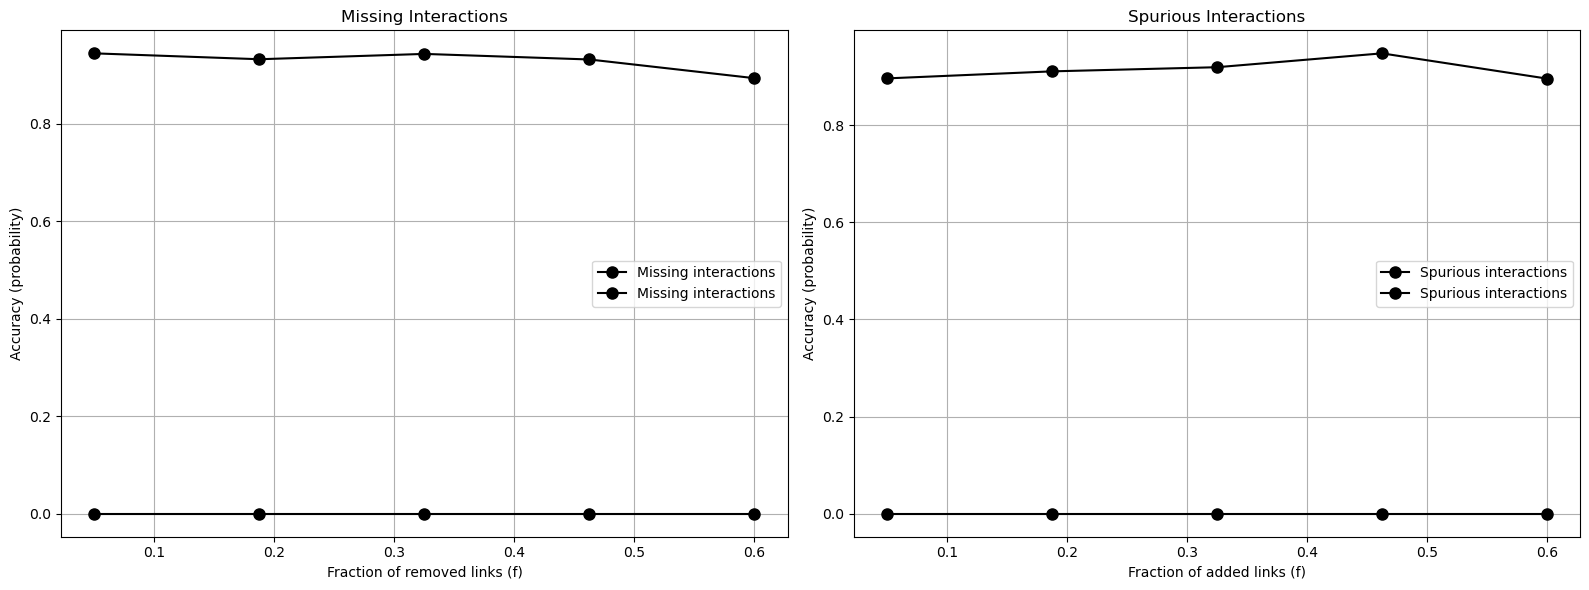

c:\Users\eugen\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\eugen\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


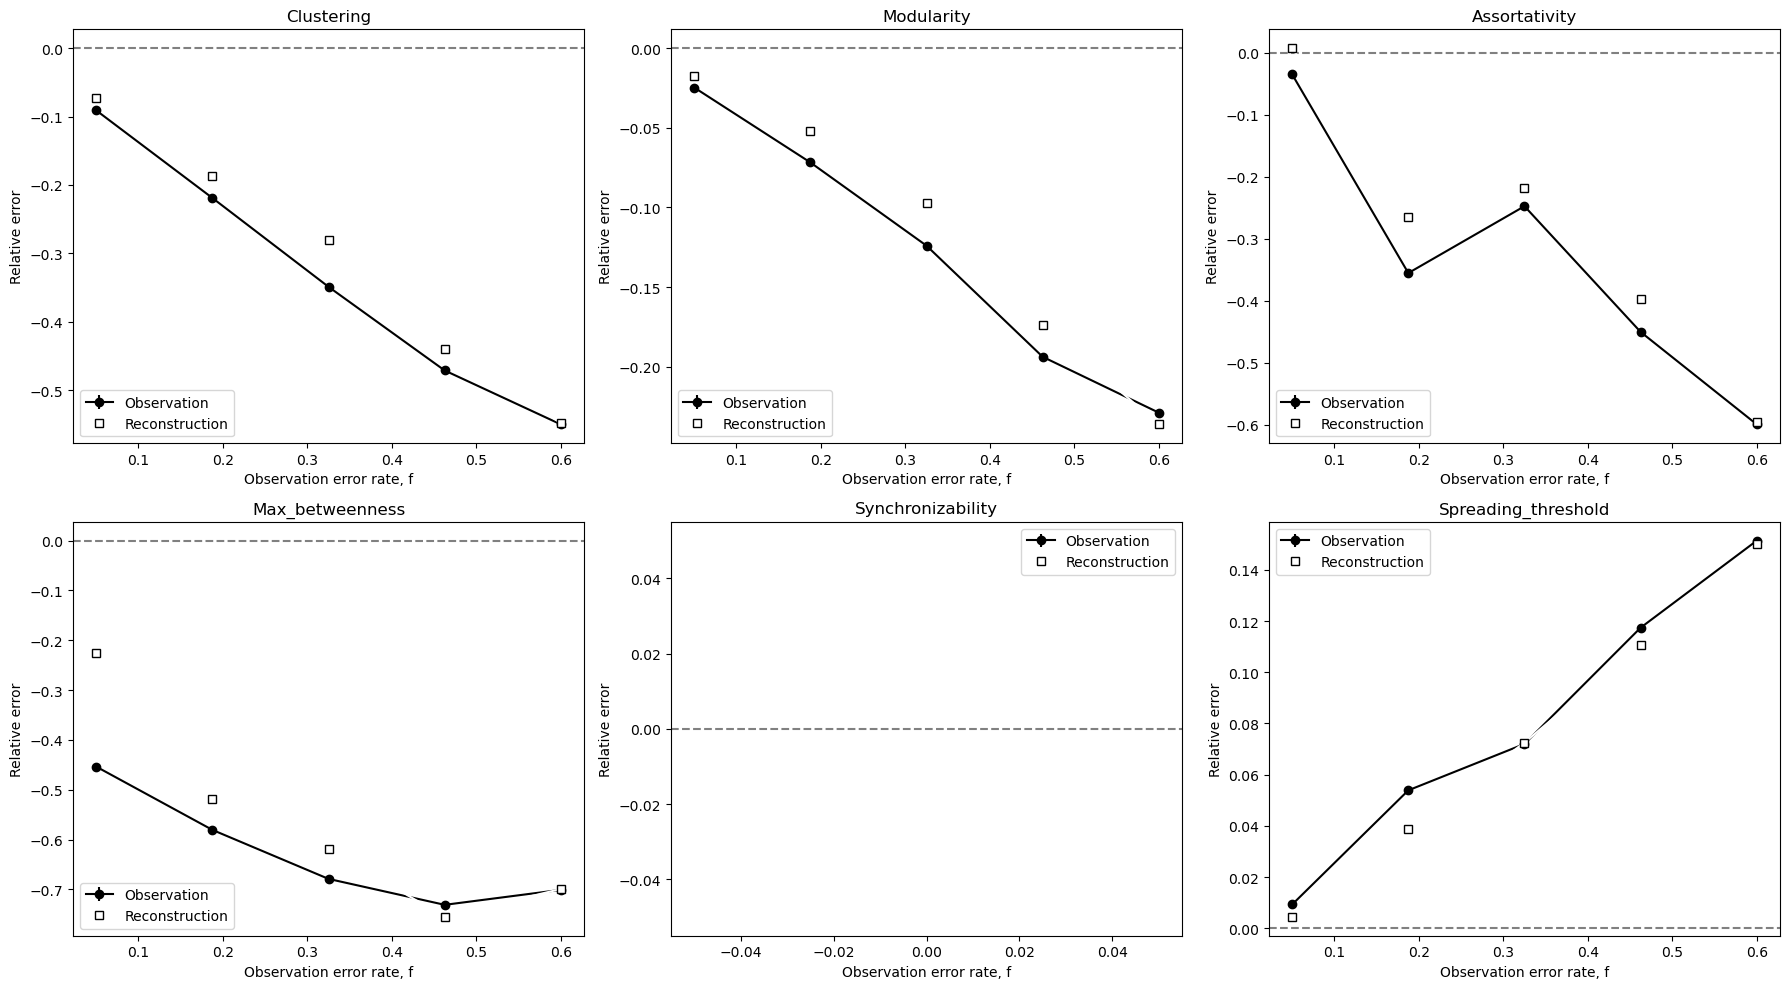

In [33]:
run_full_analysis = True  # Cambia in True per eseguire tutta l'analisi

if run_full_analysis:
    # Parametri
    error_fractions = np.linspace(0.05, 0.6, 5)  # come nell'articolo
    n_repeats = 1  # o 25 per media/statistica
    num_samples = 75000
    equilibration = 37000

    # Esegui la funzione
    relerr_obs_all, relerr_rec_all, accuracy_missing, accuracy_spurious = calculate_accuracies_and_properties(
        G_true,
        error_fractions,
        num_samples=num_samples,
        equilibration=equilibration,
        n_repeats=n_repeats,
        thinning_auto=False,         # o True se vuoi thinning automatico
        thinning_interval=200        # usato se thinning_auto=False
    )

    # --- PLOT accuracies ---
    plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious)

    # --- PLOT errori relativi delle proprietà ---
    prop_names = ['clustering', 'modularity', 'assortativity', 'max_betweenness', 'synchronizability', 'spreading_threshold']
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    for idx, p in enumerate(prop_names):
        obs_means = [relerr_obs_all[p][i][0] for i in range(len(error_fractions))]
        obs_stds  = [relerr_obs_all[p][i][1] for i in range(len(error_fractions))]
        rec_means = [relerr_rec_all[p][i][0] for i in range(len(error_fractions))]
        rec_stds  = [relerr_rec_all[p][i][1] for i in range(len(error_fractions))]
        axs[idx].errorbar(error_fractions, obs_means, yerr=obs_stds, fmt='ko-', label='Observation')
        axs[idx].errorbar(error_fractions, rec_means, yerr=rec_stds, fmt='ws-', markeredgecolor='black', label='Reconstruction')
        axs[idx].axhline(0, color='gray', linestyle='--')
        axs[idx].set_title(p.capitalize())
        axs[idx].set_xlabel('Observation error rate, f')
        axs[idx].set_ylabel('Relative error')
        axs[idx].legend()
    plt.tight_layout()
    plt.show()